In [98]:

import os
import numpy as np
import torch
from torch import nn
from scipy.stats import ortho_group
from typing import Union
from typing_extensions import Literal
from pytorch_lightning import LightningModule, Trainer
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms

from torchvision.datasets import MNIST
PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 10000 if AVAIL_GPUS else 64
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from scipy.linalg import block_diag
from sklearn.linear_model import LinearRegression
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.rcParams['font.size'] = 14

## Blockwise MCC (instead of summing |correlations| this sums R2 across blocks)

In [25]:
def MCC_block_r2(Z,Zp,b):
    n = np.shape(Z)[1]
    s = np.arange(0,n,b)
    l = np.shape(s)[0]
    R2_matrix = np.zeros((l,l))
    c=0
    for i in list(s):
        d=0
        for j in list(s):
            
            reg = LinearRegression().fit(Z[:,i:i+b], Zp[:,j:j+b])
            R2_matrix[c,d] = reg.score(Z[:,i:i+b], Zp[:,j:j+b])
            d=d+1
        c=c+1
    print(R2_matrix)
    
    r,c = linear_sum_assignment(-R2_matrix)
    
    return np.mean(R2_matrix[r,c])

In [26]:
def MCC(Z,Zp):
    n = np.shape(Z)[1]
#     print (n)
    rho_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            rho_matrix[i,j] = np.abs(np.corrcoef(Z[:,i], Zp[:,j])[0,1])
    
    r,c = linear_sum_assignment(-rho_matrix)
    
    return np.mean(rho_matrix[r,c])

## Invertible MLP function from CIDGP paper

In [27]:
## Invertible MLP function from CIDGP paper

def construct_invertible_mlp(
    n: int = 20,
    n_layers: int = 2,
    n_iter_cond_thresh: int = 10000,
    cond_thresh_ratio: float = 0.25,
    weight_matrix_init: Union[Literal["pcl"], Literal["rvs"]] = "pcl",
    act_fct: Union[
        Literal["relu"],
        Literal["leaky_relu"],
        Literal["elu"],
        Literal["smooth_leaky_relu"],
        Literal["softplus"],
    ] = "leaky_relu",
):
   
    """
    Create an (approximately) invertible mixing network based on an MLP.
    Based on the mixing code by Hyvarinen et al.
    Args:
        n: Dimensionality of the input and output data
        n_layers: Number of layers in the MLP.
        n_iter_cond_thresh: How many random matrices to use as a pool to find weights.
        cond_thresh_ratio: Relative threshold how much the invertibility
            (based on the condition number) can be violated in each layer.
        weight_matrix_init: How to initialize the weight matrices.
        act_fct: Activation function for hidden layers.
    """

    class SmoothLeakyReLU(nn.Module):
        def __init__(self, alpha=0.2):
            super().__init__()
            self.alpha = alpha

        def forward(self, x):
            return self.alpha * x + (1 - self.alpha) * torch.log(1 + torch.exp(x))

    def get_act_fct(act_fct):
        if act_fct == "relu":
            return torch.nn.ReLU, {}, 1
        if act_fct == "leaky_relu":
            return torch.nn.LeakyReLU, {"negative_slope": 0.2}, 1
        elif act_fct == "elu":
            return torch.nn.ELU, {"alpha": 1.0}, 1
        elif act_fct == "max_out":
            raise NotImplemented()
        elif act_fct == "smooth_leaky_relu":
            return SmoothLeakyReLU, {"alpha": 0.2}, 1
        elif act_fct == "softplus":
            return torch.nn.Softplus, {"beta": 1}, 1
        else:
            raise Exception(f"activation function {act_fct} not defined.")

    layers = []
    act_fct, act_kwargs, act_fac = get_act_fct(act_fct)

    # Subfuction to normalize mixing matrix
    def l2_normalize(Amat, axis=0):
        # axis: 0=column-normalization, 1=row-normalization
        l2norm = np.sqrt(np.sum(Amat * Amat, axis))
        Amat = Amat / l2norm
        return Amat
    print (n_iter_cond_thresh)
    condList = np.zeros([n_iter_cond_thresh])
    if weight_matrix_init == "pcl":
        for i in range(n_iter_cond_thresh):
            A = np.random.uniform(-1, 1, [n, n])
            A = l2_normalize(A, axis=0)
            condList[i] = np.linalg.cond(A)
        condList.sort()  # Ascending order
    condThresh = condList[int(n_iter_cond_thresh * cond_thresh_ratio)]
    print("condition number threshold: {0:f}".format(condThresh))

    for i in range(n_layers):

        lin_layer = nn.Linear(n, n, bias=False)

        if weight_matrix_init == "pcl":
            condA = condThresh + 1
            while condA > condThresh:
                weight_matrix = np.random.uniform(-1, 1, (n, n))
                weight_matrix = l2_normalize(weight_matrix, axis=0)

                condA = np.linalg.cond(weight_matrix)
                # print("    L{0:d}: cond={1:f}".format(i, condA))
            print(
                f"layer {i+1}/{n_layers},  condition number: {np.linalg.cond(weight_matrix)}"
            )
            lin_layer.weight.data = torch.tensor(weight_matrix, dtype=torch.float32)

        elif weight_matrix_init == "rvs":
            weight_matrix = ortho_group.rvs(n)
            lin_layer.weight.data = torch.tensor(weight_matrix, dtype=torch.float32)
        elif weight_matrix_init == "expand":
            pass
        else:
            raise Exception(f"weight matrix {weight_matrix_init} not implemented")

        layers.append(lin_layer)

        if i < n_layers - 1:
            layers.append(act_fct(**act_kwargs))

    mixing_net = nn.Sequential(*layers)

    # fix parameters
    for p in mixing_net.parameters():
        p.requires_grad = False

    return mixing_net

## Data generation function 

In [28]:
def data_generation_MLP(n, n_layers, cond_thresh_ratio, n_iter_cond_thresh, n_data, distribution):
    
    if(distribution == "uniform_non_linear_block"): # all components of z are uniform i.i.d.
        data_Z        = np.random.rand(n_data, n)*5.0
        tensor_Z      = torch.Tensor(data_Z)


    if(distribution == "normal_non_linear_block"): # all components of z are uniform i.i.d.
        A1 = np.ones((n//2,n//2))
        A2 = np.ones((n//2,n//2))
        A = block_diag(A1,A2)
        data_Z = np.random.multivariate_normal(mean=np.zeros(n), cov=np.eye(n)+ A@A.T, size=n_data, check_valid='warn', tol=1e-8)
        tensor_Z      = torch.Tensor(data_Z)

    g = construct_invertible_mlp(n, n_layers,   n_iter_cond_thresh, cond_thresh_ratio)  
    data = g(tensor_Z)


    data_Z_list   = [tensor_Z]
    data_X_list     = [data]
    offset_1 = torch.ones(n_data,2)
    offset_2 = torch.cat((torch.ones((n_data,1)), 2.0*torch.ones((n_data,1))), axis=1)

    for i in range(n):

        if(i<=n//2-1):

            tensor_Z_copy = torch.clone(tensor_Z)
            tensor_Z_copy[:,2*i:2*i+2] = tensor_Z_copy[:,2*i:2*i+2] + offset_1
            data_copy = g(tensor_Z_copy)
            data_Z_list.append(tensor_Z_copy)
            data_X_list.append(data_copy)
        else:
            j = i-n//2
            tensor_Z_copy = torch.clone(tensor_Z)
            tensor_Z_copy[:,2*j:2*j+2] = tensor_Z_copy[:,2*j:2*j+2] + offset_2
            data_copy = g(tensor_Z_copy)
            data_Z_list.append(tensor_Z_copy)
            data_X_list.append(data_copy)                   

    return data_X_list, data_Z_list  
        

## Construct the model and loss (compares intervened and default latent)

In [29]:
class Latent_comparison_model(LightningModule):
    def __init__(self,n):
        super().__init__()
        self.n     = n
        num_hidden = 100
        self.linear1 = nn.Linear(self.n, num_hidden)
        self.act_fn1 = nn.ReLU()
        self.linear2 = nn.Linear(num_hidden, num_hidden)
        self.act_fn2 = nn.ReLU()
        self.linear3 = nn.Linear(num_hidden, self.n)
        
    def forward(self, x):
       
        x = self.linear1(x)
        x = self.act_fn1(x)
        x = self.linear2(x)
        x = self.act_fn2(x)
        x = self.linear3(x)
        
        return x

    def training_step(self, batch_X_list):
        L      = len(batch_X_list)
        X_0    = batch_X_list[0]
        n_d    = X_0.size()[0]
        offset = torch.ones(n_d)
        loss   = 0.0      
        offset_matrix1 = np.random.RandomState(1).uniform(1, 5, size=(self.n,2))
        offset_matrix2 = np.random.RandomState(2).uniform(1, 5, size=(self.n,2))
#       
       
        for i in range(L-1):
            if(i <=(L-1)//2-1):
                offset_1 = torch.ones((n_d,2))*offset_matrix1[i]
                Z_target  = self(batch_X_list[i+1])
                Z_predict = self(X_0) 
                Z_predict[:,2*i:2*i+2] = Z_predict[:,2*i:2*i+2] + offset_1 
                loss = loss + F.mse_loss(Z_predict, Z_target)
            else:
                offset_2 = torch.ones((n_d,2))*offset_matrix2[i]
                j=i-(L-1)//2
                Z_target  = self(batch_X_list[i+1])
                Z_predict = self(X_0) 
                Z_predict[:,2*j:2*j+2] = Z_predict[:,2*j:2*j+2] + offset_2 
                loss = loss + F.mse_loss(Z_predict, Z_target)
        return loss
    
    def validation_step(self, batch_X_list):
        L      = len(batch_X_list)
        X_0    = batch_X_list[0]
        n_d    = X_0.size()[0]
        offset = torch.ones(n_d)
        loss   = 0.0
        for i in range(1,L):
            Z_target  = self(batch_X_list[i])
            Z_predict = self(X_0) 
            Z_predict[:,i-1] = Z_predict[:,i-1] + offset 
            loss = loss + F.mse_loss(Z_predict, Z_target)
            
            
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.005)

## Generate data

In [30]:
n=10
data_X, data_Z = data_generation_MLP(n=n, n_layers=1, cond_thresh_ratio=0.0, n_iter_cond_thresh=25000, n_data=15000, distribution="uniform_non_linear_block")

k= len(data_X)
train_data_X = []
test_data_X  = []
train_data_Z = []
test_data_Z  = []
train_size = 10000
for i in range(k):
    train_data_X.append(data_X[i][:train_size])
    train_data_Z.append(data_Z[i][:train_size])
    test_data_X.append(data_X[i][train_size:])
    test_data_Z.append(data_Z[i][train_size:])

25000
condition number threshold: 3.808828
layer 1/1,  condition number: 3.4803772092920506


## Train model 

In [31]:
latent_comparison_model = Latent_comparison_model(n)
train_loader = DataLoader(train_data_X, batch_size=BATCH_SIZE)

trainer = Trainer(
    gpus=AVAIL_GPUS,
    max_epochs=2000,
    progress_bar_refresh_rate=20,
)
trainer.fit(latent_comparison_model, train_loader)

/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

Training: 0it [00:00, ?it/s]

## Output BMCC and R2 matrix 

In [32]:
Zp=latent_comparison_model(test_data_X[0])
Z = test_data_Z[0]
Zp_np= Zp.detach().numpy()
Z_np    = Z.detach().numpy()
MCC_block_r2(Zp_np,Z_np,2)

[[9.99997739e-01 5.27518346e-04 9.29967367e-04 5.59339865e-04
  3.10385549e-04]
 [5.26843556e-04 9.99993415e-01 2.82735643e-04 3.53248189e-04
  1.78464436e-04]
 [9.81019893e-04 2.76630864e-04 9.99993023e-01 6.26349244e-04
  8.51935685e-05]
 [6.63439220e-04 3.81079412e-04 5.69731824e-04 9.99984573e-01
  4.94359683e-04]
 [2.50444376e-04 1.67962184e-04 7.92842106e-05 6.86247312e-04
  9.99982227e-01]]


0.9999901953512607

## Generate results (Uniform)

In [12]:
n_trials=5
dim_list = [6,10,20]
s = len(dim_list)
MCC_result = np.zeros((s,n_trials))
MCC_result1 = np.zeros((s,n_trials))
m=0
for d in dim_list:
    for trial in range(n_trials):
        data_X, data_Z = data_generation_MLP(n=d, n_layers=2, cond_thresh_ratio=0.0, n_iter_cond_thresh=25000, n_data=15000, distribution="uniform_non_linear_block")
        k= len(data_X)
        train_data_X = []
        test_data_X  = []
        train_data_Z = []
        test_data_Z  = []
        train_size = 10000
        for i in range(k):
            train_data_X.append(data_X[i][:train_size])
            train_data_Z.append(data_Z[i][:train_size])
            test_data_X.append(data_X[i][train_size:])
            test_data_Z.append(data_Z[i][train_size:])  
        latent_comparison_model = Latent_comparison_model(d)
        train_loader = DataLoader(train_data_X, batch_size=BATCH_SIZE)
        trainer = Trainer(
            gpus=AVAIL_GPUS,
            max_epochs=2000,
            progress_bar_refresh_rate=20,
        )
        trainer.fit(latent_comparison_model, train_loader)
        
        Zp=latent_comparison_model(test_data_X[0])
        Z = test_data_Z[0]
        MCC_result[m][trial] = MCC_block_r2(Z.detach().numpy(),Zp.detach().numpy(),2)
        MCC_result1[m][trial] = MCC(Z.detach().numpy(),Zp.detach().numpy())
    
    m=m+1
        

25000
condition number threshold: 1.867214
layer 1/2,  condition number: 1.8654361586918646


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

layer 2/2,  condition number: 1.735258525951


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

[[9.99996187e-01 8.93615394e-04 6.22536848e-04]
 [2.39509470e-04 9.99994839e-01 1.18157864e-04]
 [4.80919536e-04 5.54596530e-04 9.99997446e-01]]
25000
condition number threshold: 1.954855
layer 1/2,  condition number: 1.8619961493317756


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

layer 2/2,  condition number: 1.932525937713316


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

[[9.99981330e-01 4.90254186e-04 4.20843698e-04]
 [6.32411832e-04 9.99968756e-01 2.16285962e-04]
 [5.30105032e-04 1.46187111e-04 9.99970230e-01]]
25000
condition number threshold: 2.079968
layer 1/2,  condition number: 2.0386101790037294


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

layer 2/2,  condition number: 2.0611598208676876


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

[[9.99998903e-01 1.09853015e-04 4.62685279e-04]
 [1.01018589e-05 9.99995362e-01 9.57519760e-04]
 [5.05854368e-04 5.35454100e-04 9.99996277e-01]]
25000
condition number threshold: 2.137966
layer 1/2,  condition number: 2.0106226205990865

/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v


layer 2/2,  condition number: 2.0620399027572054


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

[[9.99929359e-01 3.53754380e-04 2.25895873e-04]
 [1.03407370e-04 9.99937874e-01 2.92580634e-04]
 [6.89338420e-04 6.44322321e-04 9.99917155e-01]]
25000
condition number threshold: 1.911110
layer 1/2,  condition number: 1.757140822321727


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

layer 2/2,  condition number: 1.5377379048389912


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

[[9.99998944e-01 6.93155596e-04 9.12550544e-04]
 [9.53878533e-04 9.99998660e-01 7.01132226e-04]
 [1.24193268e-04 3.53425465e-04 9.99999157e-01]]
25000
condition number threshold: 4.197077
layer 1/2,  condition number: 4.083422100677182


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

layer 2/2,  condition number: 4.1381422071921055


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

[[9.99736470e-01 7.05055259e-04 2.40099628e-04 8.12568943e-04
  3.27284121e-04]
 [2.29158194e-04 9.99846506e-01 3.76978378e-04 5.59519880e-04
  1.81544590e-04]
 [5.96321930e-04 6.40508388e-04 9.99899610e-01 2.63801444e-04
  1.88633832e-04]
 [1.31789305e-03 7.76925422e-04 2.44224407e-04 9.99666946e-01
  1.06345311e-03]
 [4.26804190e-04 4.45060232e-04 1.48300076e-04 1.16639538e-03
  9.99750768e-01]]
25000
condition number threshold: 4.253594


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

layer 1/2,  condition number: 4.128753720134301
layer 2/2,  condition number: 4.058928301791323


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

[[9.99755330e-01 1.40293543e-04 7.84810212e-04 9.26879218e-04
  2.85965716e-04]
 [1.41405170e-03 9.99305669e-01 1.64826519e-04 6.30472550e-04
  1.33340311e-03]
 [3.40541444e-04 5.84024297e-04 9.99398677e-01 4.09192544e-04
  1.42270808e-04]
 [1.25641270e-03 9.09648569e-04 3.14241978e-04 9.99828067e-01
  1.38427504e-04]
 [5.66182766e-04 1.05066389e-03 1.30244956e-04 8.34351376e-05
  9.99579432e-01]]
25000
condition number threshold: 4.133631
layer 1/2,  condition number: 4.015182346876323


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

layer 2/2,  condition number: 3.6779420498380704


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

[[9.99950602e-01 2.19720835e-04 1.07827809e-03 5.27112955e-04
  3.77564545e-04]
 [2.46897015e-04 9.99759702e-01 1.77271899e-04 3.16541198e-04
  3.07753636e-04]
 [3.70849403e-04 2.85480461e-04 9.99913713e-01 1.60219389e-04
  3.99390244e-04]
 [7.90552299e-05 2.40662679e-04 2.39347163e-04 9.99847087e-01
  6.74301211e-04]
 [5.15374614e-04 9.45224506e-04 3.41919164e-04 6.77879702e-04
  9.99727311e-01]]
25000
condition number threshold: 4.201496
layer 1/2,  condition number: 3.9179556694581708


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

layer 2/2,  condition number: 3.7970324903600776


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

[[9.99929051e-01 1.30557346e-04 7.84584324e-04 1.96116627e-04
  5.30875296e-05]
 [1.62769021e-04 9.99972469e-01 3.31321747e-04 3.18893888e-05
  3.85912696e-04]
 [6.66451816e-04 5.07086206e-04 9.99956863e-01 2.65031608e-04
  1.24617533e-03]
 [2.26953589e-04 9.40950240e-05 3.74319725e-04 9.99951043e-01
  7.99336345e-04]
 [3.39107969e-05 7.18348212e-05 1.15416911e-03 7.07840639e-04
  9.99974317e-01]]
25000
condition number threshold: 4.260722
layer 1/2,  condition number: 3.877203642205684


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

layer 2/2,  condition number: 3.5020698343584002


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

[[9.99898873e-01 5.45886391e-05 4.01242916e-04 3.77490270e-05
  7.85591194e-04]
 [8.76793857e-04 9.99977558e-01 1.85849488e-04 2.85650406e-04
  7.71493549e-04]
 [2.88090172e-04 1.80507901e-04 9.99965669e-01 6.19693906e-04
  2.32600415e-04]
 [2.55534530e-05 3.44122271e-04 7.97308244e-04 9.99954438e-01
  5.21525531e-04]
 [3.74818431e-04 1.24012383e-03 2.17279937e-04 4.32133371e-04
  9.99921181e-01]]
25000
condition number threshold: 8.858494
layer 1/2,  condition number: 7.903365213898813


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

layer 2/2,  condition number: 8.593617357444414


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

[[9.95939177e-01 7.16181889e-04 1.74578748e-04 1.31471484e-03
  5.79452592e-04 6.92879759e-03 2.37157811e-04 1.38374174e-03
  6.71654264e-04 1.20899625e-03]
 [8.06005426e-04 9.95351720e-01 6.82578218e-04 6.20889936e-04
  7.19052264e-04 3.31677836e-03 9.74798964e-04 7.78641601e-04
  1.21471131e-03 1.88243722e-03]
 [2.01517015e-04 5.36504463e-04 9.95428781e-01 1.11188536e-03
  5.91644478e-04 7.69239015e-03 2.51797927e-04 3.96506841e-04
  1.63251529e-03 5.72625202e-04]
 [1.98797805e-04 4.86953652e-04 4.09620453e-04 9.97180644e-01
  6.19242903e-04 3.41401700e-04 2.00200715e-04 5.79035185e-04
  1.29116199e-03 3.29526952e-04]
 [4.99706368e-04 1.50179071e-04 4.08308649e-04 5.72353594e-04
  9.94462182e-01 4.32153725e-03 3.25672727e-04 1.25452124e-03
  2.22385055e-04 3.35291046e-04]
 [1.03800394e-03 2.29028783e-03 5.14114214e-03 7.80239502e-05
  3.74269643e-03 9.65181091e-01 3.37011283e-04 4.44828706e-03
  2.60270178e-03 1.07213555e-03]
 [7.31806445e-04 1.43451288e-03 1.89786000e-04 1.91928644e

/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

layer 2/2,  condition number: 8.843849052450294


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

[[8.79960816e-01 1.29391030e-03 1.25907628e-02 1.32535879e-02
  8.96474515e-02 3.68412013e-03 3.21427241e-03 1.85035789e-02
  1.12164531e-02 1.21446831e-02]
 [3.46464732e-03 9.14170269e-01 1.79680557e-03 1.23489840e-02
  4.10248499e-04 9.57480753e-03 1.38650659e-02 5.98946610e-03
  5.54591561e-03 2.53999002e-02]
 [1.71517082e-03 2.83438102e-03 8.61660876e-01 1.21527812e-02
  2.89360120e-02 5.29457429e-03 9.98787428e-03 2.45150817e-02
  2.21886848e-02 2.58854391e-02]
 [4.43586749e-02 9.60529233e-03 5.94699700e-03 9.02081529e-01
  1.13440726e-02 3.18145432e-02 4.47138142e-03 3.74837840e-02
  4.96022720e-03 1.09522682e-02]
 [1.08002581e-02 9.24887338e-04 3.95652703e-02 4.81015753e-03
  7.13554344e-01 1.06455745e-01 8.96219622e-03 4.10005809e-02
  5.28486318e-02 3.51164739e-02]
 [3.14110716e-03 4.55425722e-03 2.44033067e-03 9.02161192e-03
  6.88348752e-02 8.34869902e-01 1.67967114e-03 2.59781283e-03
  1.51857825e-03 2.44907027e-03]
 [1.77388038e-02 2.00293007e-02 1.25040445e-02 2.08954184e

/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

layer 2/2,  condition number: 8.965171697600379


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

[[7.11063350e-01 1.32003547e-01 1.03106976e-02 7.75214088e-03
  7.18927655e-04 1.20293079e-02 1.23860641e-02 3.71701309e-02
  1.81418002e-02 8.76232483e-03]
 [1.66987142e-01 7.06169419e-01 8.38312621e-03 2.55213259e-02
  3.30623896e-02 4.93551091e-03 9.82751132e-03 3.80412828e-02
  1.57521791e-02 1.47067403e-02]
 [9.22480235e-04 1.58126955e-03 9.52255612e-01 3.50753764e-03
  3.52739052e-03 4.86405413e-04 1.34011499e-02 6.00416546e-03
  7.60219388e-03 2.14243976e-03]
 [1.29338006e-02 2.57473679e-02 3.98468907e-03 8.92200897e-01
  1.03393200e-02 1.05369161e-02 1.26041006e-02 8.59403719e-04
  5.93750595e-03 3.29227873e-03]
 [1.36974122e-02 4.52502950e-03 8.71027046e-04 5.17415796e-03
  9.09120790e-01 1.72804529e-03 4.42993966e-03 1.32992236e-02
  1.03895889e-02 4.91104978e-04]
 [1.00414583e-03 1.59222674e-02 7.26975597e-04 1.85146746e-02
  6.32783218e-04 8.22640630e-01 3.67137946e-03 5.41306499e-02
  3.11608078e-02 1.20640455e-02]
 [1.37731179e-02 3.03257269e-03 7.91589536e-03 8.42478538e

/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

layer 2/2,  condition number: 9.259306022468639


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

[[6.43852365e-01 4.45751820e-02 2.86940538e-02 2.42598625e-02
  5.30928843e-03 1.05959710e-02 8.12493353e-02 1.82900847e-01
  1.28567170e-02 4.02385224e-03]
 [1.85191549e-02 7.23381487e-01 3.34610373e-03 3.38590447e-02
  3.46341802e-03 8.15297468e-03 2.09671168e-02 1.79617932e-02
  8.66150745e-03 1.10995198e-01]
 [7.67643492e-02 2.10209485e-02 6.93280606e-01 5.40569215e-03
  1.23543139e-02 1.09615250e-01 3.83049420e-02 1.12716792e-02
  2.82108428e-03 3.54703888e-02]
 [4.77227412e-02 2.76320262e-02 7.60045529e-03 6.74739893e-01
  2.85406100e-02 4.26476473e-02 2.19159847e-02 9.07752395e-03
  4.55509627e-04 3.69514392e-02]
 [3.33795191e-03 1.90271353e-02 1.78695840e-04 2.13980602e-01
  7.48349357e-01 8.96613810e-03 7.53975831e-03 2.37763254e-04
  9.63238394e-03 9.69747172e-03]
 [1.36054360e-03 7.90616032e-04 2.90041169e-02 3.75665249e-02
  1.05719521e-01 7.39599810e-01 8.81946174e-03 1.22024705e-02
  1.98822940e-04 5.78059197e-02]
 [5.62125876e-02 3.99721693e-02 7.13194210e-02 3.64111588e

/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

layer 2/2,  condition number: 7.898551531098178


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

[[8.69685599e-01 1.08888938e-02 2.15003365e-02 2.77881127e-03
  2.47868952e-03 2.13024985e-02 1.70545764e-02 5.87282195e-03
  1.46319917e-03 3.87156761e-02]
 [9.80067829e-03 8.04636845e-01 3.90481487e-02 3.51960650e-03
  4.29646328e-02 4.59623513e-03 4.68315082e-03 2.26642022e-02
  7.94055321e-03 1.70176401e-02]
 [2.01805362e-02 1.59901376e-02 7.75712927e-01 3.11111115e-02
  1.01670882e-02 2.40980021e-02 1.05833274e-02 2.24807487e-02
  8.05946069e-04 3.73491671e-02]
 [2.08689980e-03 7.61917620e-03 1.05350508e-02 8.04714047e-01
  4.83770167e-03 1.06843966e-02 1.05676330e-02 1.27732992e-01
  1.13907608e-02 9.84981246e-03]
 [6.29597354e-03 4.91699393e-02 4.78133547e-02 2.51450692e-02
  9.06187988e-01 8.76082215e-03 2.79100658e-02 3.20658424e-03
  3.25090325e-03 9.39163858e-04]
 [5.31223668e-03 4.02719174e-02 1.98490555e-02 2.32531454e-03
  7.55334191e-03 8.81329672e-01 5.82474430e-04 7.18795329e-02
  1.42129910e-02 1.79538971e-02]
 [2.29395137e-02 2.45627816e-03 1.17761822e-02 1.40031553e

In [13]:
MCC_result

array([[0.99999616, 0.99997344, 0.99999685, 0.99992813, 0.99999892],
       [0.99978006, 0.99957343, 0.99983968, 0.99995675, 0.99994354],
       [0.99189238, 0.8527501 , 0.85027789, 0.70921437, 0.83303777]])

## Generate results (Normal)

In [15]:
n_trials=5
dim_list = [6,10,20]
s = len(dim_list)
MCC_result = np.zeros((s,n_trials))
MCC_result1 = np.zeros((s,n_trials))
m=0
for d in dim_list:
    for trial in range(n_trials):
        data_X, data_Z = data_generation_MLP(n=d, n_layers=2, cond_thresh_ratio=0.0, n_iter_cond_thresh=25000, n_data=15000, distribution="normal_non_linear_block")
        k= len(data_X)
        train_data_X = []
        test_data_X  = []
        train_data_Z = []
        test_data_Z  = []
        train_size = 10000
        for i in range(k):
            train_data_X.append(data_X[i][:train_size])
            train_data_Z.append(data_Z[i][:train_size])
            test_data_X.append(data_X[i][train_size:])
            test_data_Z.append(data_Z[i][train_size:])  
        latent_comparison_model = Latent_comparison_model(d)
        train_loader = DataLoader(train_data_X, batch_size=BATCH_SIZE)
        trainer = Trainer(
            gpus=AVAIL_GPUS,
            max_epochs=2000,
            progress_bar_refresh_rate=20,
        )
        trainer.fit(latent_comparison_model, train_loader)
        
        Zp=latent_comparison_model(test_data_X[0])
        Z = test_data_Z[0]
        MCC_result[m][trial] = MCC_block_r2(Z.detach().numpy(),Zp.detach().numpy(),2)
        MCC_result1[m][trial] = MCC(Z.detach().numpy(),Zp.detach().numpy())
        
    m=m+1
        

25000
condition number threshold: 2.032986
layer 1/2,  condition number: 2.0174957391064696


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

layer 2/2,  condition number: 1.9768273267870224


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

[[9.99994478e-01 3.17904673e-01 1.69909063e-04]
 [4.83026050e-01 9.99995111e-01 5.01776372e-01]
 [1.01558273e-04 3.22973547e-01 9.99994415e-01]]
25000
condition number threshold: 2.263918


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

layer 1/2,  condition number: 2.170786261905988
layer 2/2,  condition number: 2.052746119919558


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

[[9.99998721e-01 3.21053082e-01 7.29817825e-04]
 [4.83688984e-01 9.99994092e-01 4.99201981e-01]
 [1.24564083e-03 3.15707037e-01 9.99979138e-01]]
25000
condition number threshold: 2.120995


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

layer 1/2,  condition number: 2.116138258211186
layer 2/2,  condition number: 2.113989339183946


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

[[9.99998555e-01 3.29215014e-01 6.47671920e-04]
 [4.97585911e-01 9.99998089e-01 4.93732551e-01]
 [7.57641522e-04 3.16197370e-01 9.99997674e-01]]
25000
condition number threshold: 1.858617
layer 1/2,  condition number: 1.8240254792713697


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

layer 2/2,  condition number: 1.8265009838606492


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

[[9.99985480e-01 3.23488515e-01 3.09899686e-04]
 [4.96671902e-01 9.99995440e-01 5.05119153e-01]
 [2.46659337e-04 3.11010308e-01 9.99997457e-01]]
25000
condition number threshold: 2.002473


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

layer 1/2,  condition number: 2.0009779544668853
layer 2/2,  condition number: 1.8772225237816194


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

[[9.99997829e-01 3.29298808e-01 6.20985681e-05]
 [5.06065648e-01 9.99997541e-01 4.84210076e-01]
 [3.00008145e-05 3.12216169e-01 9.99998391e-01]]
25000
condition number threshold: 3.739169
layer 1/2,  condition number: 3.58345508066753


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

layer 2/2,  condition number: 3.665705614212573


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

[[9.99959696e-01 8.19152977e-01 4.47952572e-01 2.56174662e-04
  1.98612075e-04]
 [7.52300286e-01 9.99976414e-01 4.42337727e-01 2.75491125e-04
  3.15124489e-04]
 [6.86564301e-01 7.46643350e-01 9.99988014e-01 6.51001018e-01
  6.46111787e-01]
 [1.24921699e-04 6.78364547e-05 3.11136237e-01 9.99975462e-01
  7.09190510e-01]
 [7.80754365e-05 2.69006098e-04 3.10401484e-01 7.10826791e-01
  9.99947847e-01]]
25000
condition number threshold: 3.929714
layer 1/2,  condition number: 3.51320888474529


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

layer 2/2,  condition number: 3.8597700687526597


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

[[9.99990236e-01 8.21522776e-01 4.44063613e-01 7.59222747e-04
  3.49429770e-04]
 [7.52906758e-01 9.99995204e-01 4.41254640e-01 7.39376070e-04
  6.60709003e-04]
 [6.87863822e-01 7.44900181e-01 9.99994798e-01 6.31755740e-01
  6.25573540e-01]
 [9.24679405e-04 8.18124800e-04 3.00292563e-01 9.99966217e-01
  6.81479627e-01]
 [6.76287129e-04 8.77941473e-04 3.00557727e-01 6.88316643e-01
  9.99875630e-01]]
25000
condition number threshold: 3.931544
layer 1/2,  condition number: 3.695511283308994


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

layer 2/2,  condition number: 3.511720474433701


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

[[9.99978232e-01 8.29221218e-01 4.59213004e-01 6.21121173e-05
  7.27503500e-05]
 [7.59708505e-01 9.99997186e-01 4.56617457e-01 1.20465625e-04
  5.48730737e-05]
 [7.01965045e-01 7.63766052e-01 9.99996744e-01 6.39714888e-01
  6.41600165e-01]
 [6.12966623e-05 4.22205617e-05 3.03768675e-01 9.99994721e-01
  6.90878436e-01]
 [3.89853203e-05 3.04621295e-05 3.04838441e-01 6.97239921e-01
  9.99978028e-01]]
25000
condition number threshold: 3.371969
layer 1/2,  condition number: 3.260558218625193


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

layer 2/2,  condition number: 2.9734475805485077


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

[[9.99997152e-01 8.20719195e-01 4.52624785e-01 1.19097958e-04
  1.90369163e-04]
 [7.54363370e-01 9.99999360e-01 4.50241443e-01 1.97742012e-04
  3.71001686e-04]
 [6.97432736e-01 7.57614896e-01 9.99993933e-01 6.39941932e-01
  6.39985391e-01]
 [1.16560517e-04 1.73937675e-04 3.04006082e-01 9.99999526e-01
  6.96485422e-01]
 [5.42047144e-04 1.05913885e-03 3.06750442e-01 7.04950901e-01
  9.99988700e-01]]
25000
condition number threshold: 3.773191
layer 1/2,  condition number: 3.6628370759174658


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

layer 2/2,  condition number: 3.7640373910070166


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

[[9.99978341e-01 8.24911191e-01 4.57432978e-01 2.53995863e-04
  3.69111174e-04]
 [7.63056158e-01 9.99990137e-01 4.55460804e-01 1.75146183e-04
  4.60203982e-04]
 [6.99662848e-01 7.50408590e-01 9.99986703e-01 6.38730149e-01
  6.36899241e-01]
 [3.00174290e-04 2.33945474e-04 2.99675170e-01 9.99981008e-01
  7.02706483e-01]
 [7.29776914e-04 6.40969225e-04 3.04035274e-01 7.06952209e-01
  9.99987927e-01]]
25000
condition number threshold: 9.226555
layer 1/2,  condition number: 8.926555780966963


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

layer 2/2,  condition number: 8.13241836003153


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

[[9.99625244e-01 7.61121415e-01 8.14336772e-01 8.32626627e-01
  8.20545752e-01 6.84050115e-04 4.10663355e-05 2.11757504e-04
  7.53371952e-04 2.43826818e-04]
 [8.01127767e-01 9.96995242e-01 8.14055790e-01 8.31098009e-01
  8.10048390e-01 2.80052829e-03 1.04618475e-03 1.00503491e-03
  3.41292144e-03 1.72086443e-03]
 [8.03508638e-01 7.61919785e-01 9.99488488e-01 8.33155667e-01
  8.13205630e-01 6.27410087e-04 4.12224720e-04 1.18576815e-04
  6.65986018e-04 2.26859899e-04]
 [8.05888871e-01 7.61579143e-01 8.16357392e-01 9.99837394e-01
  8.12080745e-01 1.27730711e-03 1.23351442e-04 6.47763168e-04
  1.05389548e-03 6.09994556e-04]
 [8.05290784e-01 7.62236472e-01 8.15525690e-01 8.33254777e-01
  9.98335284e-01 1.17096494e-03 8.38749537e-05 2.75694602e-04
  1.52114868e-03 3.19727484e-04]
 [7.59893934e-04 3.09345288e-03 4.60050308e-04 5.82191856e-05
  7.68485932e-04 9.98123073e-01 8.39973675e-01 7.75576716e-01
  8.81849207e-01 8.58234419e-01]
 [5.79677745e-04 2.88192671e-03 2.56097733e-04 1.25371742e

/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

layer 2/2,  condition number: 8.023959344293305


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

[[9.93942933e-01 7.60208575e-01 8.16423863e-01 8.25481588e-01
  8.10413183e-01 1.26888865e-03 2.26708196e-03 1.98363463e-03
  6.60521224e-04 2.72648747e-03]
 [7.86898996e-01 9.98717332e-01 8.15057698e-01 8.25328161e-01
  8.10391182e-01 1.00402848e-03 1.84813946e-03 1.89948137e-03
  5.43348940e-04 1.81800156e-03]
 [7.87205852e-01 7.58661654e-01 9.99194056e-01 8.28928433e-01
  8.09399001e-01 9.45280308e-04 1.63498776e-03 1.79775105e-03
  6.13375026e-04 1.79608776e-03]
 [7.86944099e-01 7.59221802e-01 8.17100858e-01 9.96587324e-01
  8.09703862e-01 2.57462987e-03 2.70410886e-03 3.02037213e-03
  9.13471257e-04 3.81595853e-03]
 [7.82746393e-01 7.59592638e-01 8.14755060e-01 8.28123487e-01
  9.97526373e-01 9.07457515e-04 1.76615855e-03 1.60900029e-03
  5.63959052e-04 1.87866034e-03]
 [3.59483522e-03 6.71695546e-04 5.97502828e-04 3.39855781e-03
  1.32236176e-03 9.98272546e-01 8.37913744e-01 7.75847941e-01
  8.90821792e-01 8.58932243e-01]
 [3.97623606e-03 9.10324458e-04 5.36950271e-04 3.34189275e

/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

layer 2/2,  condition number: 7.203955581445388


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

[[9.95343064e-01 7.45304667e-01 8.06583394e-01 8.23641696e-01
  8.07861268e-01 7.20744520e-04 4.04626918e-04 1.03260737e-03
  2.69301670e-04 2.77084221e-04]
 [7.84688172e-01 9.98666544e-01 8.06158193e-01 8.26440268e-01
  8.10600410e-01 3.79821198e-04 3.16140463e-04 1.21504273e-03
  9.11234600e-05 1.90665443e-04]
 [7.85358035e-01 7.46521169e-01 9.99379760e-01 8.24539922e-01
  8.10233156e-01 3.59201286e-04 3.54659421e-04 9.54781310e-04
  1.70650339e-04 1.77650260e-04]
 [7.82865612e-01 7.46959516e-01 8.05950932e-01 9.99875660e-01
  8.08054542e-01 6.63742974e-04 4.48507058e-04 1.18151528e-03
  2.92268577e-04 2.90068493e-04]
 [7.86134446e-01 7.47470589e-01 8.07802573e-01 8.27529792e-01
  9.98907857e-01 6.33951786e-04 4.01342190e-04 1.07841557e-03
  2.03058951e-04 2.19675202e-04]
 [4.23104825e-03 1.05289893e-03 5.16436067e-04 3.26617691e-04
  1.03644526e-03 9.99260640e-01 8.36109264e-01 7.66223836e-01
  8.86454474e-01 8.54829921e-01]
 [5.14030132e-03 1.00276959e-03 5.10762873e-04 3.50783511e

/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

layer 2/2,  condition number: 9.21781394406336


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

[[9.80110577e-01 7.83721891e-01 8.20025825e-01 8.65732592e-01
  8.31266759e-01 1.62333324e-03 9.58451527e-04 9.17258401e-04
  8.94148678e-04 3.82440582e-03]
 [8.03907955e-01 9.89649062e-01 8.18766278e-01 8.62984634e-01
  8.30717748e-01 5.88906810e-04 9.10320143e-04 3.39298370e-03
  1.04718711e-03 9.68837062e-04]
 [8.05275727e-01 7.81751095e-01 9.86195967e-01 8.67773815e-01
  8.30112661e-01 8.22898436e-04 6.66242411e-04 1.82240250e-03
  1.01360486e-03 1.12262417e-03]
 [8.05887041e-01 7.83942577e-01 8.23439464e-01 9.78134487e-01
  8.27970652e-01 1.26852319e-03 7.41148795e-04 4.65937012e-03
  5.96089971e-04 2.55726309e-03]
 [8.02680733e-01 7.81831185e-01 8.20088168e-01 8.58642243e-01
  9.95311812e-01 6.44036604e-05 6.12918622e-04 7.26651272e-04
  4.81851243e-04 1.05654417e-03]
 [1.58953110e-02 1.64421893e-03 8.05898683e-03 1.13504022e-02
  8.36506276e-04 9.96303631e-01 8.37249014e-01 7.73988835e-01
  8.90050744e-01 8.74442593e-01]
 [1.51903800e-02 1.62146381e-03 8.16357411e-03 1.00134706e

/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `v

layer 2/2,  condition number: 9.034736630846542


/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

[[9.99782897e-01 7.53551803e-01 8.23475317e-01 8.32168312e-01
  8.24285594e-01 3.26042860e-05 7.41775113e-04 7.79370698e-04
  2.17210925e-04 3.53197638e-04]
 [7.99002697e-01 9.97151871e-01 8.21896683e-01 8.34696518e-01
  8.23950786e-01 5.87099074e-04 7.45557195e-04 8.10588861e-04
  2.88216965e-04 4.04341959e-04]
 [8.02373347e-01 7.54010795e-01 9.99819353e-01 8.32639843e-01
  8.22585687e-01 3.32856414e-04 1.05238506e-03 8.64169850e-04
  2.82865023e-04 7.30044334e-04]
 [7.99522100e-01 7.53005454e-01 8.21985240e-01 9.97399049e-01
  8.23167150e-01 1.28652535e-04 1.25503928e-03 7.97600630e-04
  2.66471871e-04 6.27025268e-04]
 [8.01040057e-01 7.54585623e-01 8.22416140e-01 8.35125713e-01
  9.99531631e-01 1.31493193e-03 1.49605191e-03 1.42506699e-03
  8.40784848e-04 1.20710203e-03]
 [4.84879619e-04 3.26411298e-03 1.78045459e-04 5.23979210e-04
  1.25916225e-03 9.99240642e-01 8.38686262e-01 7.54288382e-01
  8.82798010e-01 8.59432463e-01]
 [5.38364777e-04 3.29415306e-03 6.31159943e-04 2.14251389e

In [16]:
MCC_result

array([[0.99999467, 0.99999065, 0.99999811, 0.99999279, 0.99999792],
       [0.99996949, 0.99996442, 0.99998898, 0.99999573, 0.99998482],
       [0.99883155, 0.9975324 , 0.99888412, 0.99024976, 0.99900513]])

## Linear regression comparing the predicted and true latents

In [33]:
Zp_np = np.array([Zp.detach().numpy()[:,0]]).T
Z_np = np.array([Z.detach().numpy()[:,0]]).T
reg = LinearRegression().fit(Z_np, Zp_np)
m = reg.coef_[0]
b = reg.intercept_[0]
x = Z_np

In [34]:
Zp_np = np.array([Zp.detach().numpy()[:,1]]).T
Z_np = np.array([Z.detach().numpy()[:,1]]).T
reg = LinearRegression().fit(Z_np, Zp_np)
m1 = reg.coef_[0]
b1 = reg.intercept_[0]
x1 = Z_np

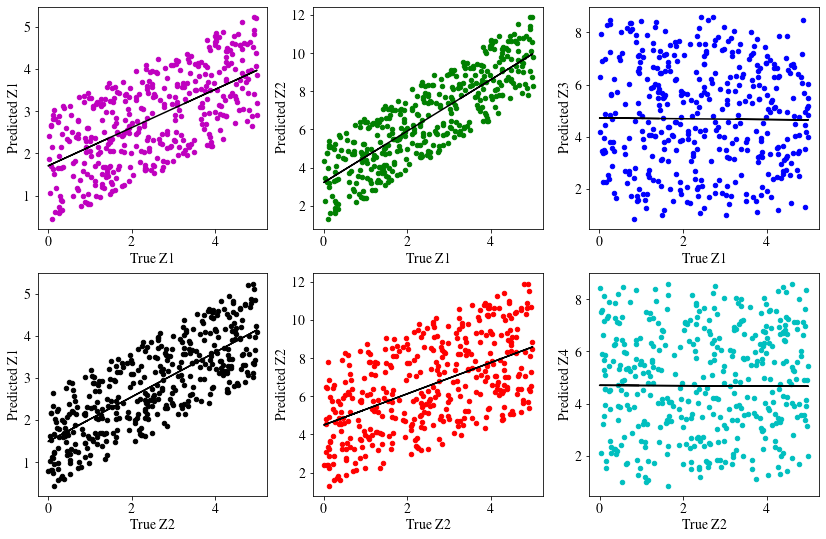

In [94]:
plt.figure(figsize=(14, 9))
plt.subplot(2, 3, 1)

plt.scatter(Z.detach().numpy()[:400,2], Zp.detach().numpy()[:400,2], c='m', s=20)

# 
y = Zp.detach().numpy()[:,2]
x = Z.detach().numpy()[:,2]

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, 'k')
plt.xlabel("True Z1")
plt.ylabel("Predicted Z1")
plt.subplot(2, 3, 2)
y = Zp.detach().numpy()[:,3]
x = Z.detach().numpy()[:,2]

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, 'k')
plt.scatter(Z.detach().numpy()[:400,2], Zp.detach().numpy()[:400,3], c='g', s=20)
# plt.plot(x1, m1*x1+b1, 'b')
plt.xlabel("True Z1")
plt.ylabel("Predicted Z2")
# plt.text(3, 0.4, r'$m=3$',
#          fontsize=15)

plt.subplot(2, 3, 4)
y = Zp.detach().numpy()[:,2]
x = Z.detach().numpy()[:,3]
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, 'k')
plt.scatter(Z.detach().numpy()[:400,3], Zp.detach().numpy()[:400,2], c='k', s=20)
plt.xlabel("True Z2")
plt.ylabel("Predicted Z1")

plt.subplot(2, 3, 5)
y = Zp.detach().numpy()[:,3]
x = Z.detach().numpy()[:,3]
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, 'k')
plt.scatter(Z.detach().numpy()[:400,3], Zp.detach().numpy()[:400,3], c='r', s=20)
plt.xlabel("True Z2")
plt.ylabel("Predicted Z2")

plt.subplot(2, 3, 3)
y = Zp.detach().numpy()[:,4]
x = Z.detach().numpy()[:,2]

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, 'k')
plt.scatter(Z.detach().numpy()[:400,2], Zp.detach().numpy()[:400,4],c='b', s=20)
plt.xlabel("True Z1")
plt.ylabel("Predicted Z3")

plt.subplot(2, 3, 6)
y = Zp.detach().numpy()[:,4]
x = Z.detach().numpy()[:,3]
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, 'k')
plt.scatter(Z.detach().numpy()[:400,3], Zp.detach().numpy()[:400,4], c='c', s=20)
plt.xlabel("True Z2")
plt.ylabel("Predicted Z4")

# plt.savefig("non-overlap_panel1.pdf")